#### Intials

In [130]:
# Cuántos nodos puedo tener donde puedo calcular la verosimilitud sin que explote?
d = 15
print(f"Para {d} nodos, tengo {2**d} combinaciones posibles para el vector X")

Para 15 nodos, tengo 32768 combinaciones posibles para el vector X


#### FVBM

Usando la FVBM, comparamos lo que tarda en calcular la verosimilitud (L) con la pseudo-verosimilitud (PL)

$\Theta = \{\theta, b\}$

$b = (b_1, b_2,\dots,b_d)$

$\theta = (\theta_{i,j})$ para $i\in\{1,\dots,d\}$ y $j<i$

In [131]:
import numpy as np
import models.fvbm as fvbm
from random import random

d = 10
theta = {}
b = {}
for i in range(d):
    for j in range(i):
        theta[(i,j)] = (random()-0.5)*4

assert(len(theta) == d*(d-1)/2)

for i in range(d):
    b[i] = (random()-0.5)*4
b_vector = np.array(list(b.values()))
assert(len(b) == d)

In [132]:
from importlib import reload
reload(fvbm)

fvbm1 = fvbm.FVBM({"theta":theta, "b":b}, d=d)

fvbm1.sample(10000)

res1 = fvbm1.fit_logpl()
res2 = fvbm1.fit_logl()

print(sum(fvbm1.pl_params_diff))
print(sum(fvbm1.l_params_diff))

8.997227258825292
8.85652468557485


In [ ]:
reload(fvbm)
from tqdm import tqdm


d = 10
MAE_fvbm = []

for _ in tqdm(range(50)):
    theta = {}
    b = {}
    for i in range(d):
        for j in range(i):
            theta[(i,j)] = (random()-0.5)*4

    assert(len(theta) == d*(d-1)/2)

    for i in range(d):
        b[i] = (random()-0.5)*4
    b_vector = np.array(list(b.values()))
    assert(len(b) == d)

    n = [2**7,2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]
    for n_ in n:
        fvbm1 = fvbm.FVBM({"theta":theta, "b":b}, d=d)
        fvbm1.sample(n_)
        
        res = fvbm1.fit_logl()
        MAE_fvbm.append({"MAE":sum(fvbm1.l_params_diff).copy(),
                    "Estimator":"MLE",
                    "n":n_}
                   )
        
        res = fvbm1.fit_logpl()
        MAE_fvbm.append({"MAE":sum(fvbm1.pl_params_diff).copy(),
                    "Estimator":"MPLE",
                    "n":n_}
                   )

100%|██████████| 50/50 [08:03<00:00,  9.68s/it]


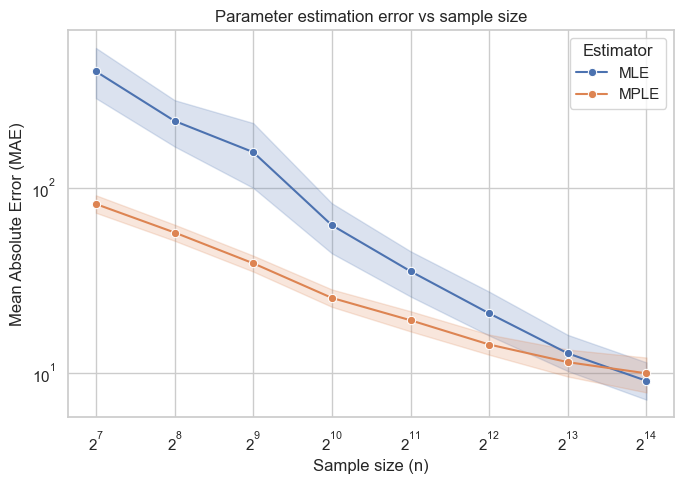

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df_fvbm = pd.DataFrame.from_dict(MAE_fvbm)
df_fvbm.to_csv("results/MLEvMPLE/fvbm.csv", index=False)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(7,5))
sns.lineplot(
    data=df_fvbm,
    x="n",
    y="MAE",
    hue="Estimator",
    marker="o"
)

plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("Sample size (n)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Parameter estimation error vs sample size")

plt.tight_layout()
plt.show()


#### FVBR-WF

In [157]:
import numpy as np
from random import random


d = 10
b = {}
alpha = {}

for i in range(d):
    b[i] = (random()-0.5)*4
    alpha[i] = (random()-0.5)*2
b_vector = np.array(list(b.values()))
alpha_vector = np.array(list(alpha.values()))
assert(len(b) == d)
assert(len(alpha) == d)
params_true = {"b":b,"alpha":alpha}

In [158]:
from importlib import reload
import models.fvbr_wf as fvbr_wf
reload(fvbr_wf)

fvbr1 = fvbr_wf.FVBR_WF(parameters=params_true, d=d)

fvbr1.sample(size=100)

fvbr1.fit_logl()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 254.50451127376846
        x: [ 4.495e+00  1.925e+00 ... -3.706e-01 -4.157e-01]
      nit: 259
      jac: [-2.994e-03 -1.809e-03 ...  1.428e-03  9.590e-04]
     nfev: 271
     njev: 271
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>

In [159]:
reload(fvbr_wf)
from tqdm import tqdm

MAE_fvbr_wf = []
d = 10

for _ in tqdm(range(50)):
    b = {}
    alpha = {}

    for i in range(d):
        b[i] = (random()-0.5)*4
        alpha[i] = (random()-0.5)*2
    b_vector = np.array(list(b.values()))
    alpha_vector = np.array(list(alpha.values()))
    assert(len(b) == d)
    assert(len(alpha) == d)
    params_true = {"b":b,"alpha":alpha}

    n = [2**6, 2**7,2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]
    MAE_l = []
    MAE_pl = []
    for n_ in n:
        fvbr1 = fvbr_wf.FVBR_WF({"alpha":alpha, "b":b}, d=d)
        fvbr1.sample(n_)
        
        res = fvbr1.fit_logl()
        MAE_fvbr_wf.append({"MAE":sum(fvbr1.l_params_diff).copy(),
                    "Estimator":"MLE",
                    "n":n_}
                   )
        
        res = fvbr1.fit_logpl()
        MAE_pl.append(sum(fvbr1.pl_params_diff).copy())
        MAE_fvbr_wf.append({"MAE":sum(fvbr1.pl_params_diff).copy(),
                    "Estimator":"MPLE",
                    "n":n_}
                   )

100%|██████████| 50/50 [17:06<00:00, 20.53s/it]


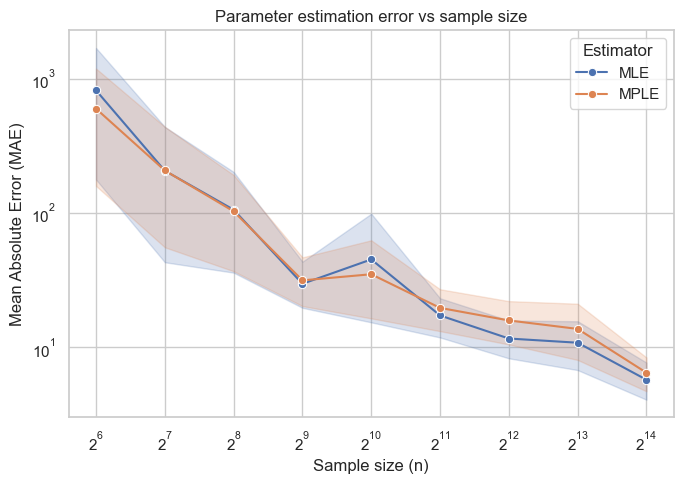

In [161]:
import pandas as pd


df_fvbr_wf = pd.DataFrame.from_dict(MAE_fvbr_wf)
df_fvbr_wf.to_csv("results/MLEvMPLE/fvbr_wf.csv", index=False)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(7,5))
sns.lineplot(
    data=df_fvbr_wf,
    x="n",
    y="MAE",
    hue="Estimator",
    marker="o"
)

plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("Sample size (n)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Parameter estimation error vs sample size")

plt.tight_layout()
plt.show()

#### FVBR-NF

In [357]:
import numpy as np
from random import random


d = 10
c = 5
gamma = {}
lambd = {}
V = {}

for i in range(d):
    V[i] = np.array([random()*4 for _ in range(c)])
    lambd[i] = [(random()-0.5)*0.5 for _ in range(c)]

gamma = [(random()-0.5)*0.5 for _ in range(c)]

V_matrix = np.array(list(V.values()))
gamma_vector = np.array(gamma)
lambd_matrix = np.array(list(lambd.values()))
assert(len(gamma) == c)
assert(len(V) == d)
assert(all([(len(v) == c) for v in V.values()]))
assert(all([(len(l) == c) for l in lambd.values()]))
params_true = {"gamma":gamma,"lambd":lambd}

In [377]:
from importlib import reload
from collections import Counter
import models.fvbr_nf as fvbr_nf
reload(fvbr_nf)

fvbr2 = fvbr_nf.FVBR_NF(parameters=params_true, nodes_features=V, d=d, c=c)
fvbr2.sample(size=100000)
print(Counter(fvbr2.samples))

fvbr2.fit_logpl()
print(fvbr2.pl_params_diff.sum())

Counter({(1, 0, 1, 0, 0, 1, 1, 0, 0, 1): 13260, (1, 0, 1, 0, 0, 1, 1, 1, 0, 1): 9042, (1, 1, 1, 0, 0, 1, 0, 0, 0, 1): 8486, (0, 1, 1, 0, 0, 1, 0, 0, 0, 1): 7500, (1, 0, 1, 0, 0, 1, 0, 0, 0, 1): 6414, (1, 0, 1, 0, 0, 1, 0, 1, 0, 1): 3974, (0, 1, 1, 0, 0, 1, 1, 0, 0, 1): 3867, (0, 0, 1, 0, 0, 1, 1, 0, 0, 1): 3286, (1, 0, 1, 0, 1, 1, 0, 0, 0, 1): 2448, (1, 1, 1, 0, 0, 1, 0, 1, 0, 1): 2378, (1, 1, 1, 0, 0, 1, 1, 0, 0, 1): 2356, (1, 0, 1, 0, 1, 1, 0, 1, 0, 1): 2030, (0, 1, 1, 0, 1, 1, 0, 0, 0, 1): 1728, (1, 0, 1, 0, 1, 1, 1, 0, 0, 1): 1598, (1, 0, 1, 0, 1, 1, 1, 1, 0, 1): 1581, (1, 1, 1, 0, 1, 1, 0, 0, 0, 1): 1527, (1, 0, 1, 0, 0, 1, 0, 0, 1, 1): 1381, (0, 1, 1, 0, 0, 0, 0, 0, 0, 1): 1158, (0, 1, 1, 0, 0, 1, 0, 1, 0, 1): 949, (0, 0, 1, 0, 0, 1, 1, 1, 0, 1): 938, (0, 0, 1, 0, 0, 1, 0, 0, 0, 1): 879, (0, 1, 1, 0, 1, 0, 0, 0, 0, 1): 785, (1, 1, 1, 0, 0, 1, 1, 1, 0, 1): 768, (1, 0, 1, 0, 0, 0, 1, 1, 0, 1): 658, (0, 1, 1, 0, 0, 0, 1, 0, 0, 1): 650, (0, 1, 1, 0, 0, 1, 0, 0, 1, 1): 607, (1, 1, 1, 

In [375]:
reload(fvbr_nf)
import time
from tqdm import tqdm


d = 10
c = 5
MAE_fvbr_nf = []
times = []
for _ in tqdm(range(50)):
    gamma = {}
    lambd = {}
    V = {}
    for i in range(d): 
        V[i] = np.array([random()*4 for _ in range(c)])
        lambd[i] = [(random()-0.5)*0.5 for _ in range(c)]
    gamma = [(random()-0.5)*0.5 for _ in range(c)]
    V_matrix = np.array(list(V.values()))
    params_true = {"gamma":gamma,"lambd":lambd}


    n = [2**6, 2**7,2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]
    MAE_l = []
    MAE_pl = []
    for n_ in n:
        fvbr2 = fvbr_nf.FVBR_NF(parameters=params_true, nodes_features=V, d=d, c=c)
        fvbr2.sample(n_)

        start_l = time.perf_counter()
        res = fvbr2.fit_logl()
        MAE_fvbr_nf.append({"MAE":sum(fvbr2.l_params_diff).copy(),
                    "Estimator":"MLE",
                    "n":n_}
                   )
        end_l = time.perf_counter()
        l_time = end_l-start_l
        times.append({"time":l_time,
                      "Estimator":"MLE",
                      "n":n_
                      }
                     )
        
        start_pl = time.perf_counter()
        res = fvbr2.fit_logpl()
        MAE_fvbr_nf.append({"MAE":sum(fvbr2.pl_params_diff).copy(),
                    "Estimator":"MPLE",
                    "n":n_}
                   )
        end_pl = time.perf_counter()
        pl_time = end_pl-start_pl
        times.append({"time":pl_time,
                      "Estimator":"MPLE",
                      "n":n_
                      }
                     ) 
        
df_fvbr_nf = pd.DataFrame.from_dict(MAE_fvbr_nf)
#df_fvbr_nf.to_csv("results/MLEvMPLE/fvbr_nf.csv", index=False)

100%|██████████| 50/50 [45:02<00:00, 54.04s/it]


In [378]:
df_fvbr_nf.to_csv("results/MLEvMPLE/fvbr_nf.csv", index=False)

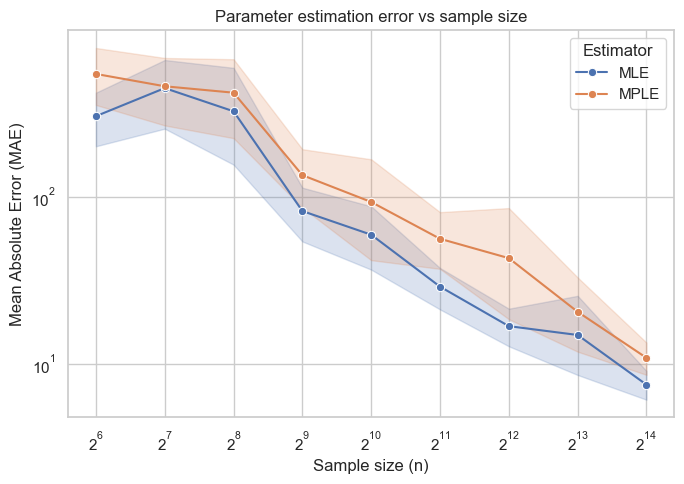

In [384]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

df_fvbr_nf = pd.read_csv("results/MLEvMPLE/fvbr_nf.csv")
sns.set_theme(style="whitegrid")

plt.figure(figsize=(7,5))
sns.lineplot(
    data=df_fvbr_nf,
    x="n",
    y="MAE",
    hue="Estimator",
    marker="o"
)

plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("Sample size (n)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Parameter estimation error vs sample size")

plt.tight_layout()
plt.show()

<Axes: xlabel='n', ylabel='time'>

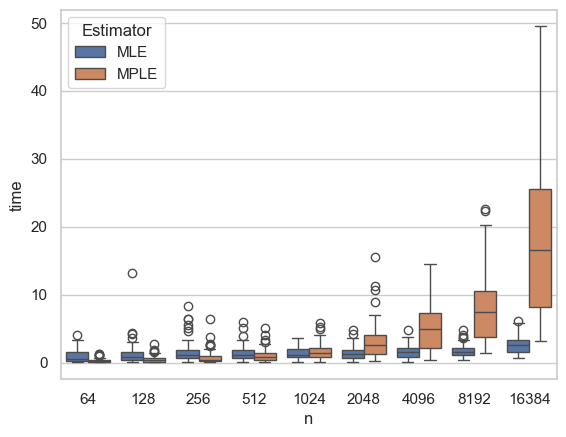

In [381]:
times_df = pd.DataFrame.from_dict(times)
sns.boxplot(times_df, x="n", y="time", hue="Estimator")